# Comparison of ExoJAX AM cloud model with VIRGA 

Here, we try to compare our cloud implementation with   a cloud opacity using Ackerman and Marley Model.
We consider the enstatite (MgSiO3) cloud.  


In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import virga.justdoit as jdi

In [2]:
# set common values
from exojax.utils.astrofunc import gravity_jupiter
fsed = 3.0
g = gravity_jupiter(1.0,1.0)
mu=2.2

import virga.justplotit as jpi
import astropy.units as u
fsed = 3
miedir = "/home/kawahara/exojax/documents/tutorials/.database/particulates/virga"
#miedir = "/home/exoplanet01/exojax/tests/integration/comparison/clouds/.database/particulates/virga"
a = jdi.Atmosphere(["MgSiO3"], fsed = fsed, mh=1.0, mmw=mu)
a.gravity(gravity=g, gravity_unit=u.Unit('cm/(s**2)'))
a.ptk(df = jdi.hot_jupiter())
all_out = jdi.compute(a, as_dict=True, directory = miedir)

pressure = all_out["pressure"]
temperature = all_out["temperature"]

In [3]:
#comparison w/ kawashima's vapor pressure code
def T_MgSiO3(P,metaldex):
    return 1e4 / (6.26 - 0.35 * np.log10(P) - 0.70 * metaldex) # Visscher et al. (2010)
def T_MnS(P,metaldex):
    return 1e4 / (7.447 - 0.42 * np.log10(P) - 0.84 * metaldex) # Morley et al. (2012)

Setting a simple atmopheric model. We need the density of atmosphere.

In [4]:
from exojax.utils.constants import kB, m_u
from exojax.atm.atmprof import pressure_layer_logspace

#Parr, dParr, k = pressure_layer_logspace(log_pressure_top=-5., log_pressure_btm=4.0, nlayer=100)
#alpha = 0.097
#T0 = 1200.
#Tarr = T0 * (Parr)**alpha

mu = 2.0  # mean molecular weight
R = kB / (mu * m_u)
rho = pressure / (R * temperature)



We import `pdb` as the particulate database class.

In [7]:
from exojax.spec.pardb import PdbCloud

pdb = PdbCloud("MgSiO3", path=miedir)
#pdb.generate_miegrid()
pdb.load_miegrid()



/home/kawahara/exojax/documents/tutorials/.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  /home/kawahara/exojax/documents/tutorials/.database/particulates/virga/MgSiO3.refrind
Miegrid file exists: /home/kawahara/exojax/documents/tutorials/.database/particulates/virga/miegrid_lognorm_MgSiO3.mg.npz
pdb.miegrid, pdb.rg_arr, pdb.sigmag_arr are now available. The Mie scattering computation is ready.


The solar abundance can be obtained using utils.zsol.nsol. Here, we assume a maximum VMR for MgSiO3 from solar abundance. 

In [8]:
from exojax.utils.zsol import nsol

n = nsol()  #solar abundance
VMR_enstatite = np.min([n["Mg"], n["Si"], n["O"] / 3])

Vapor saturation pressures can be obtained using atm.psat

In [9]:
from exojax.spec.pardb import PdbCloud
from exojax.atm.atmphys import AmpAmcloud


#from exojax.atm.psat import psat_enstatite_AM01
#P_enstatite = psat_enstatite_AM01(temperature)
P_enstatite = pdb.saturation_pressure(temperature)


Compute a cloud base pressure.

In [12]:

from exojax.atm.amclouds import compute_cloud_base_pressure
Pbase_enstatite = compute_cloud_base_pressure(pressure, P_enstatite, VMR_enstatite)


In [13]:
from bokeh.io import output_notebook
from bokeh.plotting import show, figure
from bokeh.palettes import Colorblind
output_notebook()

metallicity = 1 #atmospheric metallicity relative to Solar

#get virga recommendation for which gases to run
recommended = jdi.recommend_gas(pressure, temperature, metallicity,mu,
                #Turn on plotting
                 plot=True)
#print the results
print(recommended)


Loading BokehJS ...

['Cr', 'Mg2SiO4', 'MgSiO3', 'MnS']


The cloud base is located at the intersection of a TP profile and the vapor saturation puressure devided by VMR.

It's consistent with VIRGA and Kawashima-san's private code:


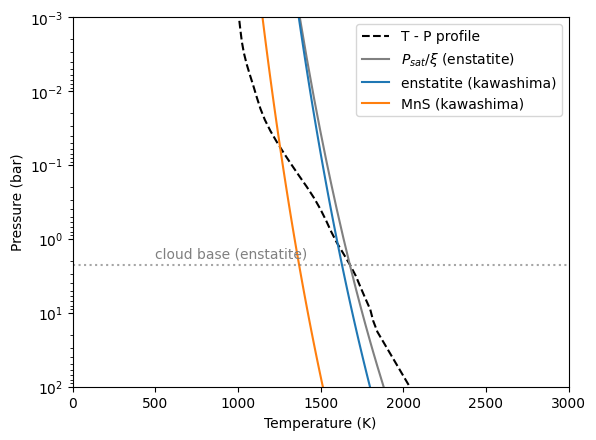

In [14]:
plt.plot(temperature, pressure, color="black", ls="dashed", label="T - P profile")
plt.plot(temperature,
         P_enstatite / VMR_enstatite,
         label="$P_{sat}/\\xi$ (enstatite)",
         color="gray")
parr=np.logspace(-3,2,100)
plt.plot(T_MgSiO3(parr,0.0),parr,label="enstatite (kawashima)")
plt.plot(T_MnS(parr,0.0),parr,label="MnS (kawashima)")

plt.axhline(Pbase_enstatite, color="gray", alpha=0.7, ls="dotted")
plt.text(500, Pbase_enstatite * 0.8, "cloud base (enstatite)", color="gray")

plt.yscale("log")
plt.ylim(1.e-3, 1.e2)
plt.xlim(0, 3000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (bar)")
plt.savefig("pbase.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("pbase.png", bbox_inches="tight", pad_inches=0.0)
plt.show()

In [ ]:
#for key, val in all_out.items():
#    print(key)

In [15]:
con_mmr = all_out["condensate_mmr"]
#con_mmr
show(jpi.condensate_mmr(all_out))

Compute VMRs of clouds. Because Parr is an array, we apply jax.vmap to atm.amclouds.VMRclouds.

In [16]:
from exojax.atm.amclouds import vmr_cloud_profile

VMRbase_enstatite = VMR_enstatite
VMRc_enstatite = vmr_cloud_profile(pressure, Pbase_enstatite, fsed, VMR_enstatite)


In [17]:
from exojax.spec.molinfo import molmass_isotope
molmass_enstatite = molmass_isotope("MgSiO3", db_HIT=False)
molmass_enstatite

100.3887

Here is the VMR distribution.

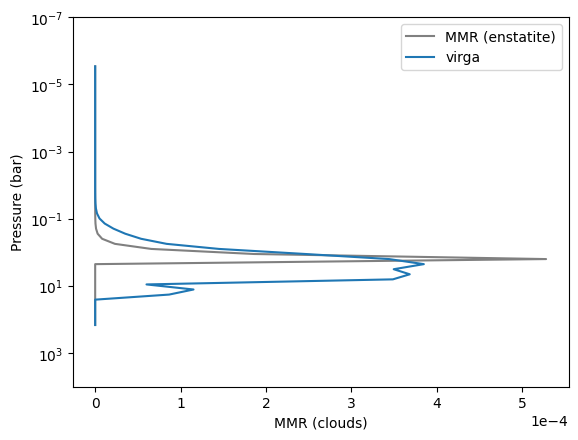

In [20]:
plt.figure()
plt.gca().get_xaxis().get_major_formatter().set_powerlimits([-3, 3])
plt.plot(VMRc_enstatite*molmass_enstatite/mu, pressure, color="gray", label="MMR (enstatite)")
plt.plot(con_mmr,pressure, label="virga")
plt.yscale("log")
plt.ylim(1.e-7, 10000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("MMR (clouds)")
plt.ylabel("Pressure (bar)")
plt.savefig("mmrcloud.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("mmrcloud.png", bbox_inches="tight", pad_inches=0.0)
plt.show()

Compute dynamic viscosity in H2 atmosphere (cm/g/s)

In [21]:
from exojax.atm.viscosity import eta_Rosner, calc_vfactor

T = np.logspace(np.log10(1000), np.log10(2000))
vfactor, Tr = calc_vfactor("H2")
eta = eta_Rosner(T, vfactor)


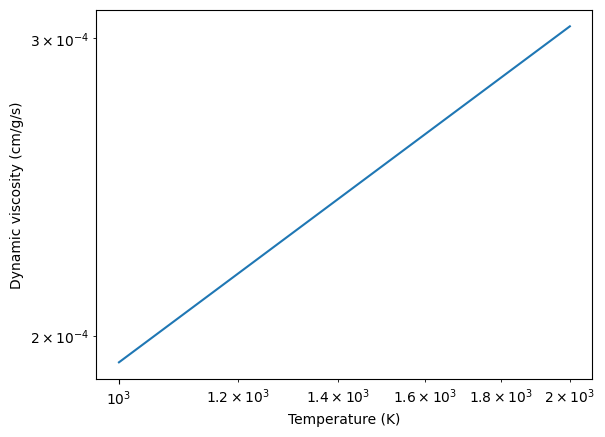

In [22]:
plt.plot(T, eta)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Temperature (K)")
plt.ylabel("Dynamic viscosity (cm/g/s)")
plt.show()

The pressure scale height can be computed using atm.atmprof.Hatm.

In [23]:
from exojax.atm.atmprof import pressure_scale_height
T = 1000  #K
print("scale height=", pressure_scale_height(1.e5, T, mu), "cm")


scale height= 415722.99317937146 cm


We need a density of condensates. 

In [24]:
from exojax.atm.condensate import condensate_density, name2formula
rhoc_enstatite = condensate_density[name2formula["enstatite"]]

from exojax.spec.molinfo import molmass_isotope

mu = molmass_isotope("H2")
muc_enstatite = molmass_isotope("MgSiO3", db_HIT=False)


Let's compute the terminal velocity. 
We can compute the terminal velocity of cloud particle using atm.vterm.vf.
vmap is again applied to vf.

In [25]:
from exojax.atm.viscosity import calc_vfactor, eta_Rosner
from exojax.atm.vterm import terminal_velocity
from jax import vmap

vfactor, trange = calc_vfactor(atm="H2")
rarr = jnp.logspace(-6, 0, 2000)  #cm
drho = rhoc_enstatite - rho
eta_fid = eta_Rosner(temperature, vfactor)

#g = 1.e5
vf_vmap = vmap(terminal_velocity, (None, None, 0, 0, 0))
vfs = vf_vmap(rarr, g, eta_fid, drho, rho)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


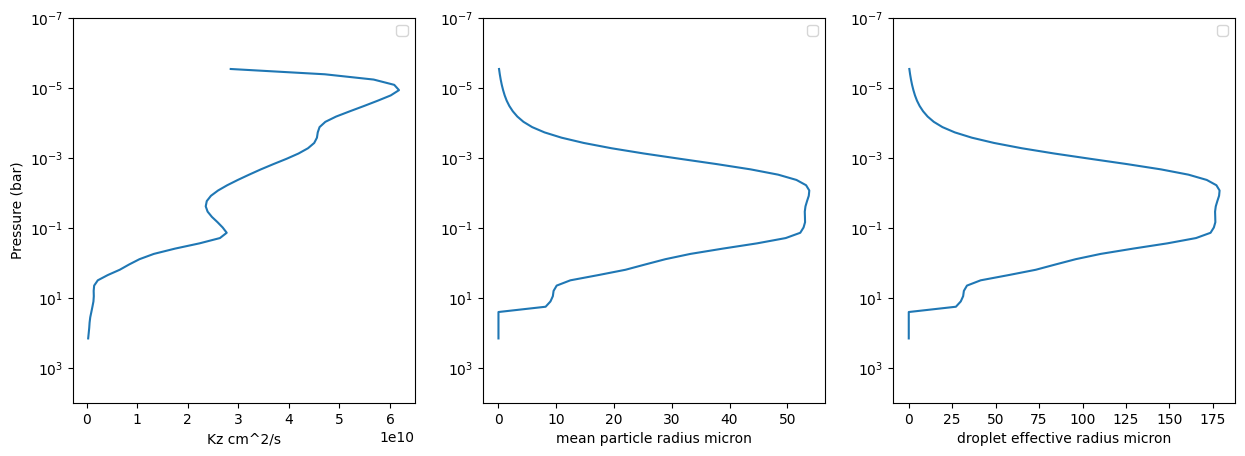

In [26]:
Kz_virga = all_out["kz"]
mpf = all_out["mean_particle_r"]
deff = all_out["droplet_eff_r"]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
plt.gca().get_xaxis().get_major_formatter().set_powerlimits([-3, 3])
plt.plot(Kz_virga,pressure)
plt.yscale("log")
plt.ylim(1.e-7, 10000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("Kz "+str(all_out["kz_unit"]))
plt.ylabel("Pressure (bar)")


ax = fig.add_subplot(132)
plt.gca().get_xaxis().get_major_formatter().set_powerlimits([-3, 3])
plt.plot(mpf,pressure)
plt.yscale("log")
plt.ylim(1.e-7, 10000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("mean particle radius " +str(all_out["r_units"]))

ax = fig.add_subplot(133)
plt.gca().get_xaxis().get_major_formatter().set_powerlimits([-3, 3])
plt.plot(deff,pressure)
plt.yscale("log")
plt.ylim(1.e-7, 10000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("droplet effective radius " +str(all_out["r_units"]))

plt.show()

In [27]:
all_out["fsed"]

3

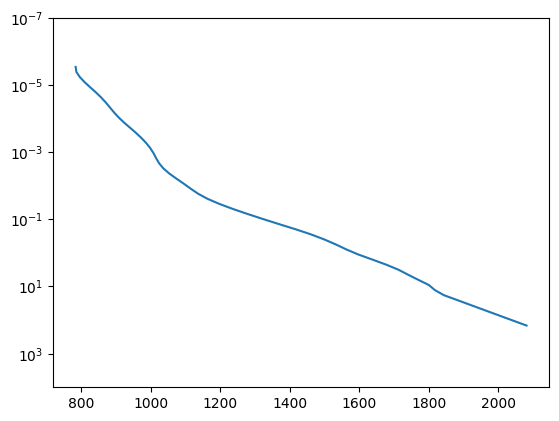

In [28]:
plt.plot(temperature, pressure)
plt.yscale("log")
plt.ylim(1.e-7, 10000)
plt.gca().invert_yaxis()


Kzz/L will be used to calibrate $r_w$. following Ackerman and Marley 2001  

In [29]:
Kzz = 3.e10  #cm2/s
sigmag = 2.0
alphav = 1.3
L = pressure_scale_height(g, 1500, mu)


In [30]:
Kzz/L

1201.748379957295

Text(0.5, 0, 'condensate size (cm)')

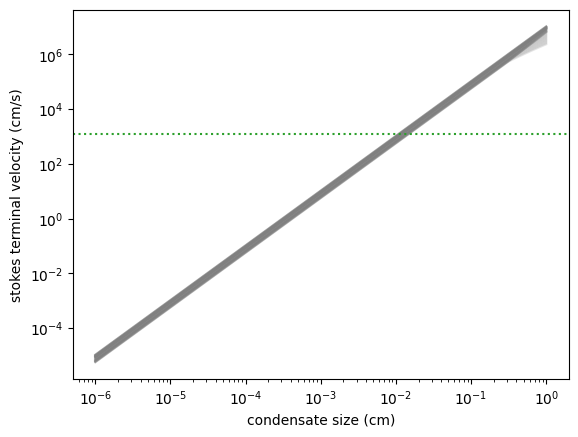

In [31]:
for i in range(0, len(temperature)):
    plt.plot(rarr, vfs[i, :], alpha=0.2, color="gray")
plt.xscale("log")
plt.yscale("log")
plt.axhline(Kzz / L, label="Kzz/H", color="C2", ls="dotted")
plt.ylabel("stokes terminal velocity (cm/s)")
plt.xlabel("condensate size (cm)")

Find the intersection.

In [32]:
from exojax.atm.amclouds import find_rw

vfind_rw = vmap(find_rw, (None, 0, None), 0)
rw = vfind_rw(rarr, vfs, Kzz / L)


Then, $r_g$ can be computed from $r_w$ and other quantities.

In [ ]:
from exojax.atm.amclouds import get_rg

rg = get_rg(rw, fsed, alphav, sigmag)


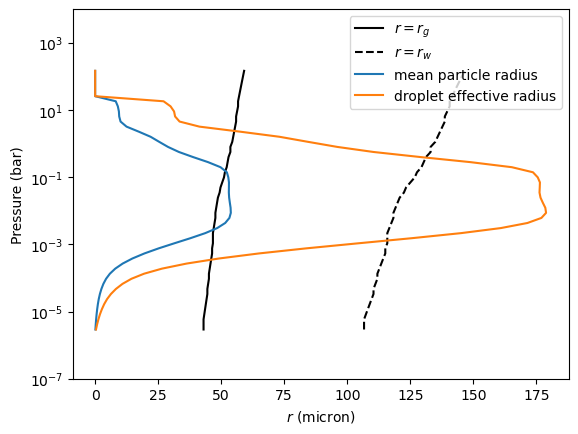

In [ ]:
plt.plot(rg * 1.e4, pressure, label="$r=r_g$", color="black")
plt.plot(rw * 1.e4, pressure, ls="dashed", label="$r=r_w$", color="black")
plt.plot(mpf,pressure, label="mean particle radius")
plt.plot(deff,pressure, label="droplet effective radius")

plt.plot()
plt.ylim(1.e-7, 10000)
plt.xlabel("$r$ (micron)")
plt.ylabel("Pressure (bar)")
plt.yscale("log")
plt.savefig("rgrw.png")
plt.legend()

This can be simply derived using `AmpAmcloud`

In [ ]:
from exojax.atm.atmphys import AmpAmcloud

amp = AmpAmcloud(pdb, bkgatm="H2")
amp.check_temperature_range(temperature)
fsed = 3.0
sigmag = 2.0
Kzz = 3.0e10

rg_layer, VMRc = amp.calc_ammodel(pressure, temperature, mu, g, fsed=fsed, sigmag=sigmag, Kzz=Kzz, VMR=VMR_enstatite)





### Mie Scattering